In [1]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import cross_validate
import tqdm

In [2]:
def get_data():
    file = open('./data/shashlik_61_pulses.txt', 'r')
    data = file.readlines()
    data = np.array([list(map(float, experiment.split())) for experiment in data])
   
    X = data[:, 2:]
    y_baseline = data[:, 1]
    y = data[:, 0]
    
    return X, y

In [3]:
X_origin, y_origin = get_data()

X_origin = np.array([experiment - np.max(experiment) for experiment in X_origin])
y_origin = np.round(y_origin)

In [4]:
def generate_multi_signal(tau, alpha, to_plot=False):
    
    ATTEMPTS_NUM = 10000
    cur_attempt = 0
    
    while cur_attempt < ATTEMPTS_NUM:
        first_idx = np.random.choice(y_origin.shape[0], 1, replace=False)[0]

        first_impulse = X_origin[first_idx]
        first_ref_time = y_origin[first_idx]

        if first_ref_time > np.mean(y_origin):
            second_ref_time = first_ref_time - tau
        else:
            second_ref_time = first_ref_time + tau

        second_idxs = np.where(y_origin == second_ref_time)[0]
        
        if len(second_idxs) > 1:
            second_idx = np.random.choice(len(second_idxs), 1, replace=False)[0]
            second_impulse = X_origin[second_idx]

            multi_impulse = first_impulse + alpha*second_impulse
            
#             print("INDEXES:")
#             print(first_idx)
#             print(second_idx)
            if to_plot:
                plt.plot(first_impulse)
                plt.plot(second_impulse)
                plt.plot(multi_impulse)
                plt.legend(['First signal', 'Second signal', 'Sum of signals'])
                plt.show()
    
            return multi_impulse
        else:
            cur_attempt += 1
            continue
    print("Value of tau = %i is too big" %tau)

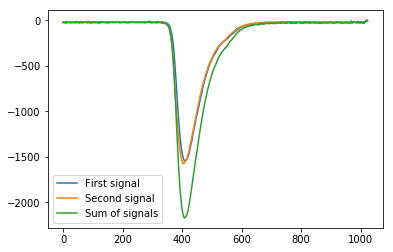

array([-25.152, -25.148, -25.334, ...,  -3.726,  -2.   ,  -5.98 ])

In [5]:
generate_multi_signal(55, 0.4, to_plot=True)

##### Fixate tau and alpha parameters

In [9]:
tau = 30
alpha = 0.01

### Preparing data

In [10]:
from sklearn.utils import shuffle

def prepare_data(tau, alpha, data_size=3000, to_print=False):
    data_size = 3000
    pos_size = int(data_size/2)
    neg_size = data_size - pos_size
    
    idxs = np.random.randint(X_origin.shape[0], size=pos_size)
    X_positive = X_origin[idxs]
    y_positive = np.ones(pos_size)
    

    X_negative = np.array([generate_multi_signal(tau, alpha) for i in range(neg_size)])
    y_negative = np.zeros(neg_size)
    

    X = np.concatenate([X_positive, X_negative])
    y = np.concatenate([y_positive, y_negative])
   
    if to_print:
        print("X positive shape:", X_positive.shape)
        print("y positive shape:", y_positive.shape)
        print("X negative shape:", X_negative.shape)
        print("y negative shape:", y_negative.shape)
        print("X shape:", X.shape)
        print("y shape:", y.shape)
    
    
    
    X, y = shuffle(X, y)

    return X, y

In [11]:
X, y = prepare_data(tau, alpha, to_print=True)

X positive shape: (1500, 1024)
y positive shape: (1500,)
X negative shape: (1500, 1024)
y negative shape: (1500,)
X shape: (3000, 1024)
y shape: (3000,)


### Splitting our data for train and test

In [12]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3)

print("X_train.shape:", X_train.shape)
print("y_train.shape", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train.shape: (2100, 1024)
y_train.shape (2100,)
X_test shape: (900, 1024)
y_test shape: (900,)


### Ensemble

In [13]:
from scipy.stats import rankdata
from itertools import cycle
from sklearn.base import BaseEstimator, ClassifierMixin

class ShuffleVoter(BaseEstimator, ClassifierMixin):  
    """
       scikit-learn based voting aggregation ensembling.
       Using bootstrapping creates a set of models, differing only by which data sample they are fed
       """

    def __init__(self, models):
        """
        model - base model ( or a pipeline ) ( unfitted )
        """
        self.models = models
        
    def ensemble_predictions(self, predictions, weights, type_="harmonic"):
        """
        Combines probabilistic class estimates using a variety of strategies.
        Linear, harmonic, geometric and rank averaging are supported at this moment. 
        Insipred by well known Abhishek's kernel on Kaggle 
        model - base model ( or a pipeline ) ( unfitted )
        """
        assert np.isclose(np.sum(weights), 1.0)
        if type_ == "linear":
            res = np.average(predictions, weights=weights, axis=0)
        elif type_ == "harmonic":
            res = np.average([1 / p for p in predictions], weights=weights, axis=0)
            return 1 / res
        elif type_ == "geometric":
            numerator = np.average(
                [np.log(p) for p in predictions], weights=weights, axis=0
            )
            res = np.exp(numerator / sum(weights))
            return res
        elif type_ == "rank":
            res = np.average([rankdata(p) for p in predictions], weights=weights, axis=0)
            return res / (len(res) + 1)
        return res


    def fit( self, X, y, n_boots = 14, test_size = 100 ):
        """
        n_boots - number of bootstrapping iterations ( and respective models built)
        """
        self.clfs  = []
        for i, model in zip(range(n_boots), cycle(self.models)):
            X_tr, X_te, y_tr, y_te = train_test_split( X, y, test_size=test_size, random_state=3521 + i*11)

            pa_clf = model
            pa_clf.fit(X_tr, y_tr)

            self.clfs.append(pa_clf)

    def predict( self, X, ensemble_type = 'rank'):
        # TODO: nonuniform weights
        
        n_boots = len( self.clfs)
        preds = [ clf.predict(X) for clf in self.clfs ]
#         return self.ensemble_predictions( preds, np.ones(n_boots)*(1/float(n_boots)), ensemble_type)
        return np.round(self.ensemble_predictions( preds, np.ones(n_boots)*(1/float(n_boots)), ensemble_type))

    
    def predict_proba( self, X, ensemble_type = 'rank' ):
        n_boots = len( self.clfs)
        preds = [ clf.predict_proba(X) for clf in self.clfs ]
        return self.ensemble_predictions( preds, np.ones(n_boots)*(1/float(n_boots)), ensemble_type)


### Defining pipelines

In [14]:
import warnings
from sklearn.preprocessing import PolynomialFeatures
from sklearn.base import TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_val_score
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.model_selection import train_test_split
warnings.filterwarnings('ignore')

In [15]:
def get_pipelines(hyperparams = {'svc_c': 0.1, 'mlp_max_iter': 1000, 'kn_n': 5, 'pa_c': 0.1}):
    SVC_pipeline = Pipeline([
                    ('clf', LinearSVC(C=hyperparams['svc_c'])),
                ])


    MLP_pipeline = Pipeline([
                    ('clf', MLPClassifier(max_iter=hyperparams['mlp_max_iter'])),
                ])

    KN_pipeline = Pipeline([
                    ('clf', KNeighborsClassifier(n_neighbors=hyperparams['kn_n'])),
                ])
    
    PA_pipeline = Pipeline([
                ('clf', PassiveAggressiveClassifier(C = hyperparams['pa_c'], max_iter=1000, tol=1e-3)),
            ])

    pipelines = {'svc': SVC_pipeline, 'kn': KN_pipeline, 'pa': PA_pipeline,  'mlp': MLP_pipeline}
    
    return pipelines

In [16]:
pipelines = get_pipelines()

### Pipelines scores:

In [17]:
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score

In [19]:
for model_name, model in pipelines.items():
    print("Model name:", model_name)
    
    scoring = {'accuracy' : make_scorer(accuracy_score), 
           'precision' : make_scorer(precision_score),
           'recall' : make_scorer(recall_score), 
           'f1_score' : make_scorer(f1_score)}
    
    scores = cross_validate(model, X, y, scoring=scoring, cv=10)
    for score in scoring.keys():
        print(score, "%0.5f (+/- %0.5f)" % (scores["test_" + score].mean(), scores["test_" + score].std() * 2))
    print('------------------------------')

Model name: svc
accuracy 0.49633 (+/- 0.01672)
precision 0.23911 (+/- 0.48145)
recall 0.38667 (+/- 0.91905)
f1_score 0.27523 (+/- 0.61970)
------------------------------
Model name: kn
accuracy 0.55167 (+/- 0.06438)
precision 0.55404 (+/- 0.06534)
recall 0.53733 (+/- 0.07035)
f1_score 0.54507 (+/- 0.06017)
------------------------------
Model name: pa
accuracy 0.49733 (+/- 0.01600)
precision 0.09785 (+/- 0.39152)
recall 0.15933 (+/- 0.66277)
f1_score 0.11964 (+/- 0.48247)
------------------------------
Model name: mlp
accuracy 0.50000 (+/- 0.01886)
precision 0.33954 (+/- 0.44851)
recall 0.40600 (+/- 0.87752)
f1_score 0.31238 (+/- 0.57539)
------------------------------


### Ensemble score

In [21]:

scoring = {'accuracy' : make_scorer(accuracy_score), 
       'precision' : make_scorer(precision_score),
       'recall' : make_scorer(recall_score), 
       'f1_score' : make_scorer(f1_score)}

scores = cross_validate(my_shuffle_voter, X, y, scoring=scoring, cv=5)
for score in scoring.keys():
    print(score, "%0.9f (+/- %0.9f)" % (scores["test_" + score].mean(), scores["test_" + score].std() * 2))

accuracy 0.554000000 (+/- 0.036061676)
precision 0.557346939 (+/- 0.035980859)
recall 0.525333333 (+/- 0.078610149)
f1_score 0.540241006 (+/- 0.050629285)


### Let's plot accuracy dependency

In [30]:
tau_values = range(0, 55, 5)
alpha_values = np.around(np.arange(0, 2, 0.05), decimals=2)

In [56]:
scores_dict = {}

for tau in tau_values:
    scores_dict[tau] = dict(zip(alpha_values, np.zeros(len(alpha_values))))

In [ ]:
for tau in tau_values:
    for alpha in tqdm.tqdm(alpha_values):
#         print("Tau:", tau)
#         print("Alpha:", alpha)
#         print("Processing...")
        
        X, y = prepare_data(tau, alpha)
        pipelines = get_pipelines()

        scoring = {'accuracy' : make_scorer(accuracy_score)}
        scores = cross_validate(pipelines['kn'], X, y, scoring=scoring, cv=5)
        
        scores_dict[tau][alpha] = scores["test_accuracy"].mean()
#         print('______________________________________')
#         print()

 82%|████████▎ | 33/40 [03:07<00:39,  5.68s/it]

In [65]:
scores_dict

{0: {0.0: 0.517,
  0.05: 0.8576666666666666,
  0.1: 0.9856666666666666,
  0.15: 1.0,
  0.2: 1.0,
  0.25: 1.0,
  0.3: 1.0,
  0.35: 1.0,
  0.4: 1.0,
  0.45: 1.0,
  0.5: 1.0,
  0.55: 1.0,
  0.6: 1.0,
  0.65: 1.0,
  0.7: 1.0,
  0.75: 1.0,
  0.8: 1.0,
  0.85: 1.0,
  0.9: 1.0,
  0.95: 1.0,
  1.0: 1.0,
  1.05: 1.0,
  1.1: 1.0,
  1.15: 1.0,
  1.2: 1.0,
  1.25: 1.0,
  1.3: 1.0,
  1.35: 1.0,
  1.4: 1.0,
  1.45: 1.0,
  1.5: 1.0,
  1.55: 1.0,
  1.6: 1.0,
  1.65: 1.0,
  1.7: 1.0,
  1.75: 1.0,
  1.8: 1.0,
  1.85: 1.0,
  1.9: 1.0,
  1.95: 1.0},
 5: {0.0: 0.4803333333333334,
  0.05: 0.8643333333333334,
  0.1: 0.9853333333333334,
  0.15: 0.9996666666666666,
  0.2: 1.0,
  0.25: 1.0,
  0.3: 1.0,
  0.35: 1.0,
  0.4: 1.0,
  0.45: 1.0,
  0.5: 1.0,
  0.55: 1.0,
  0.6: 1.0,
  0.65: 1.0,
  0.7: 1.0,
  0.75: 1.0,
  0.8: 1.0,
  0.85: 1.0,
  0.9: 1.0,
  0.95: 1.0,
  1.0: 1.0,
  1.05: 1.0,
  1.1: 1.0,
  1.15: 1.0,
  1.2: 1.0,
  1.25: 1.0,
  1.3: 1.0,
  1.35: 1.0,
  1.4: 1.0,
  1.45: 1.0,
  1.5: 1.0,
  1.55: 1.0,
 

In [ ]:
x, y, z = [], [], []
for tau, alpha_dict in scores_dict.items():
    for alpha, accuracy in alpha_dict.items():
        x.append(tau)
        y.append(alpha)
        z.append(accuracy)

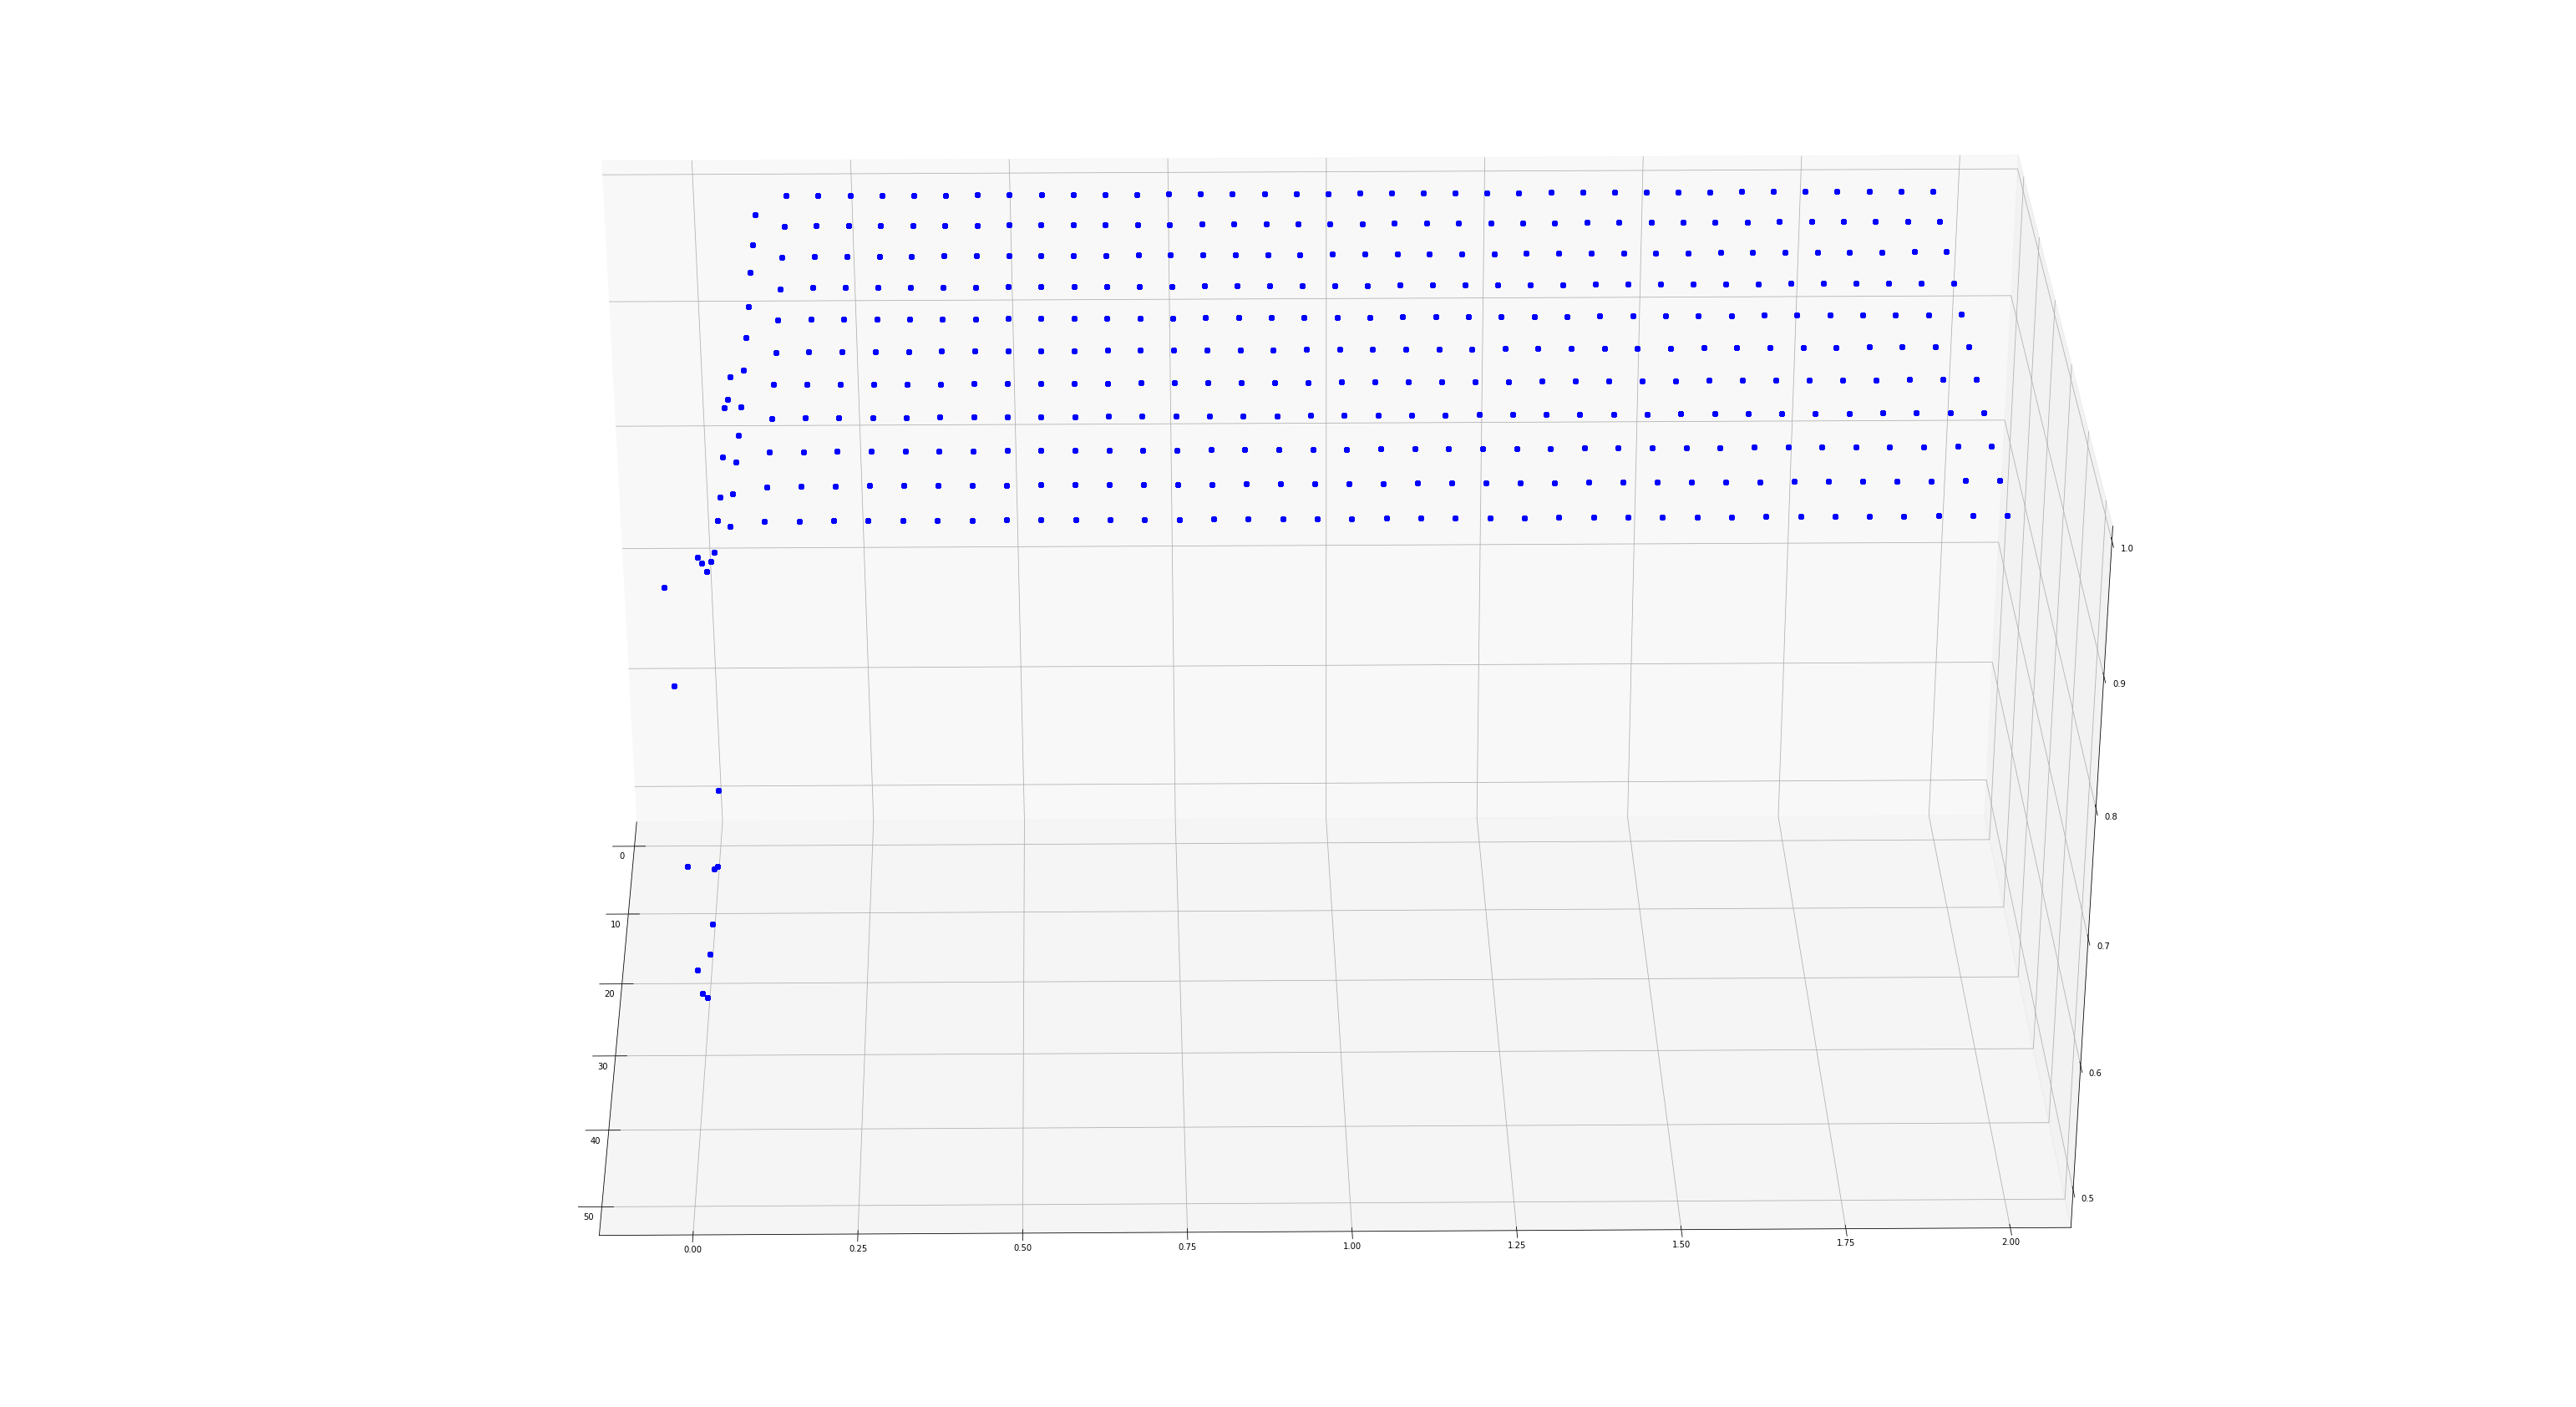

In [77]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib
matplotlib.use('Qt4Agg')


fig1 = matplotlib.pyplot.figure()
ax1 = Axes3D(fig1)

ax1.plot(10*x, 10*y, 10*z, 'ro', color='b', linewidth=3)
# ax1.plot(10*twodim_other[:, 0], 10*twodim_other[:, 1], 10*twodim_other[:, 2], 'ro', color='r', linewidth=3)

for angle in range(0, 360):
    ax1.view_init(30, angle)
    plt.draw()
    plt.pause(.001)
plt.show()

### Smaller alpha values

In [18]:
tau_values = range(0, 55, 5)
alpha_values = np.around(np.arange(0, 0.15, 0.01), decimals=2)

In [19]:
scores_dict = {}

for tau in tau_values:
    scores_dict[tau] = dict(zip(alpha_values, np.zeros(len(alpha_values))))

In [20]:
for tau in tau_values:
    for alpha in tqdm.tqdm(alpha_values):
#         print("Tau:", tau)
#         print("Alpha:", alpha)
#         print("Processing...")
        
        X, y = prepare_data(tau, alpha)
        pipelines = get_pipelines()

        scoring = {'accuracy' : make_scorer(accuracy_score)}
        scores = cross_validate(pipelines['kn'], X, y, scoring=scoring, cv=5)
        
        scores_dict[tau][alpha] = scores["test_accuracy"].mean()
#         print('______________________________________')
#         print()

100%|██████████| 15/15 [01:24<00:00,  5.61s/it]


In [21]:
scores_dict

{0: {0.0: 0.5176666666666667,
  0.01: 0.535,
  0.02: 0.6596666666666666,
  0.03: 0.736,
  0.04: 0.8176666666666665,
  0.05: 0.8633333333333333,
  0.06: 0.9043333333333334,
  0.07: 0.9406666666666667,
  0.08: 0.9606666666666666,
  0.09: 0.9790000000000001,
  0.1: 0.9886666666666667,
  0.11: 0.9896666666666667,
  0.12: 0.9933333333333334,
  0.13: 0.998,
  0.14: 0.999},
 5: {0.0: 0.51,
  0.01: 0.529,
  0.02: 0.6426666666666667,
  0.03: 0.7376666666666667,
  0.04: 0.8156666666666667,
  0.05: 0.8643333333333333,
  0.06: 0.9086666666666666,
  0.07: 0.9406666666666667,
  0.08: 0.9570000000000001,
  0.09: 0.9806666666666665,
  0.1: 0.9853333333333334,
  0.11: 0.9913333333333332,
  0.12: 0.9963333333333333,
  0.13: 0.9970000000000001,
  0.14: 0.9986666666666666},
 10: {0.0: 0.5003333333333334,
  0.01: 0.5516666666666666,
  0.02: 0.659,
  0.03: 0.7463333333333333,
  0.04: 0.8153333333333332,
  0.05: 0.869,
  0.06: 0.899,
  0.07: 0.9403333333333332,
  0.08: 0.9560000000000001,
  0.09: 0.979666666

In [23]:
x, y, z = [], [], []
for tau, alpha_dict in scores_dict.items():
    for alpha, accuracy in alpha_dict.items():
        x.append(tau)
        y.append(alpha)
        z.append(accuracy)

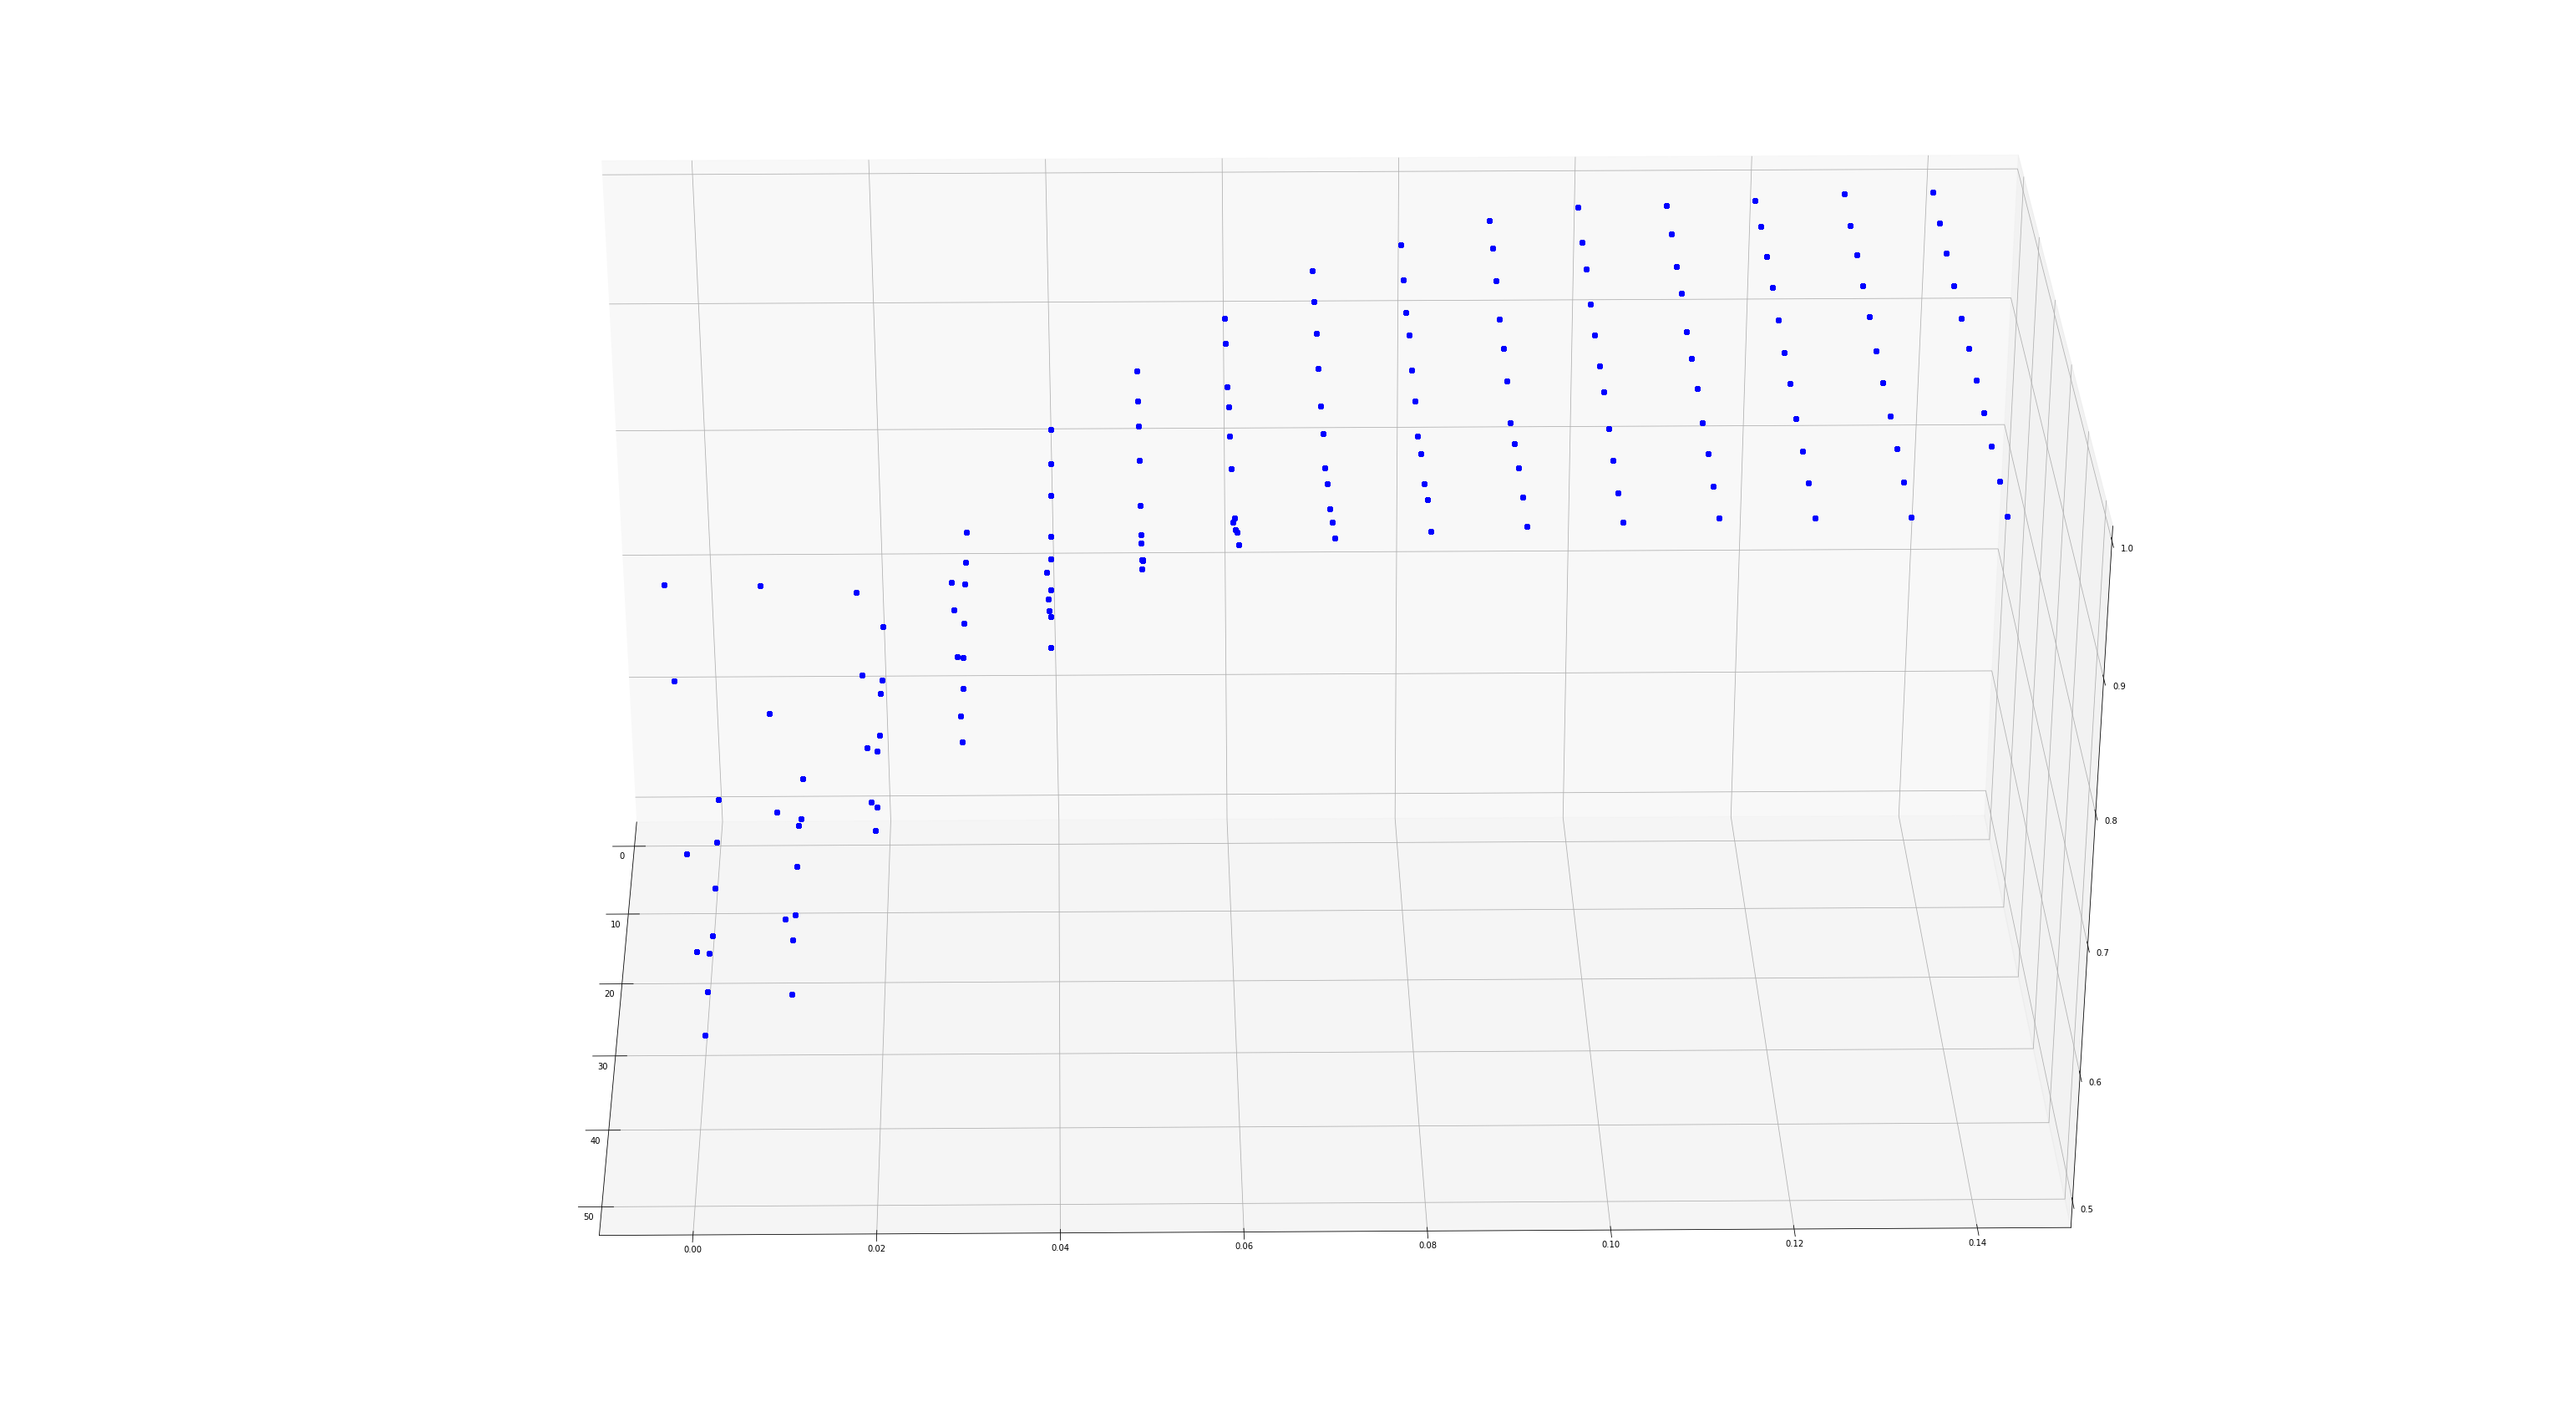

In [24]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib
matplotlib.use('Qt4Agg')


fig1 = matplotlib.pyplot.figure()
ax1 = Axes3D(fig1)

ax1.plot(10*x, 10*y, 10*z, 'ro', color='b', linewidth=3)
# ax1.plot(10*twodim_other[:, 0], 10*twodim_other[:, 1], 10*twodim_other[:, 2], 'ro', color='r', linewidth=3)

for angle in range(0, 360):
    ax1.view_init(30, angle)
    plt.draw()
    plt.pause(.001)
plt.show()